In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, RandomSampler
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

#assert torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Problem 1
Download the CIFAR10 training and test datasets.
Transform them into tensors, normalize them as described above in the code, and create DataLoaders for each one. 
For the training set, use a batch size of 32, and for the test set, use a batch size of 1.

In [3]:
classes = ('airplanes', 'cars', 'birds', 'cats', 'deer', 'dogs', 'frogs', 'horses', 'ships', 'trucks')

# transform into tensors and normalize #########################################
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((.5, .5, .5), (.5, .5, .5))])
train_data = datasets.CIFAR10('../data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10('../data', train=False, download=True, transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


In [6]:
# create DataLoaders ###########################################################
train_load = DataLoader(train_data, batch_size=32, shuffle=True)
test_load = DataLoader(test_data, batch_size=1, shuffle=True)

# Problem 2

Create a convolution model class convoles an image of size $3\times 32 \times 32$ into a 1D tensor that represents the $10$ classes.
The model should have at least three convolution layers, each followed by an activation function, and include at least two linear layers and one maxpool layer.
Select channels and kernel sizes so that you get at least $50,000$ parameters.

Calculate and print the number of learnable parameters in your model.

Initialize your model and move it to the device.
Run the model on a single image to make sure there are no errors.


In [7]:
class ConvolutionModel(nn.Module):
    def __init__(self):
        super(ConvolutionModel, self).__init__()

    # initialize the layers ####################################################
        self.relu_ = nn.ReLU()
        self.layers_ = nn.ModuleList(
          [
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5),  # 6x28x28
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),  # 10x26x26
            nn.Conv2d(in_channels=16, out_channels=24, kernel_size=3),  # 12x24x24
            nn.MaxPool2d(kernel_size=2),  # 12x12x12
            nn.Flatten(),  # 1x1728
            nn.Linear(in_features=24*12*12, out_features=100),  # 1x100
            nn.Linear(in_features=100, out_features=10),  # 1x10
          ]
        )

    def forward(self, x):
        for item in self.layers_:
            x = item(x)
            x = self.relu_(x)
        return x

# Problem 3

Train the model by looping through the training data. Inside the loop, you should
1. Zero out the gradients.
2. Run the model on the inputs.
3. Calculate the loss on the model output and the actual label.
4. Backpropogate the error.
5. Optimize.

Run the loop for 10 epochs. At the end of each epoch, calculate the mean loss of the
training data for that epoch. Then calculate the accuracy of the model on the test data. Since
the model is no longer training, it needs to be set to evaluation mode using model.eval().
To resume training at the beginning of the next epoch, set the model to training mode using
model.train().

You should have around $50\%$ accuracy at the end of $10$ epochs.

Plot the epochs v. mean training loss each epoch and the epochs v. accuracy.


In [8]:
def train(model, obj, opt, train_load, test_load, n_epochs=10):
    e_loss = []
    e_acc = []

    # for each epoch ###########################################################
    for i in range(n_epochs):
        loss_vals = []
        model.train()
        loop = tqdm(total=len(train_load), position=0)
        # run the models, calculate loss, and compute gradients ################
        for batch_ind, (images, labels) in enumerate(train_load):
            images, labels = images.to(device), labels.to(device)
            opt.zero_grad() 
            outs = model(images) 
            loss = obj(outs, labels) 
            loss.backward() 
            opt.step()
            loss_vals.append(loss.item())
            loop.set_description('loss:{:.4f}'.format(loss.item()))
            loop.update()

        model.eval()
        e_loss.append(np.mean(loss_vals))

        # check accuracy values ################################################
        acc_vals = []
        for image, label in test_load:
            image = image.to(device)
            pred = model(image).cpu()
            pred = torch.argmax(pred)
            acc_vals.append(bool(pred == label))
    
        e_acc.append(np.mean(acc_vals))

    return e_loss, e_acc


# test models ##################################################################
model = ConvolutionModel().to(device)
obj = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=1e-4)
loss, acc = train(model, obj, opt, train_load, test_load, n_epochs=10)

loss:1.4052: 100%|██████████| 1563/1563 [01:16<00:00, 20.33it/s]


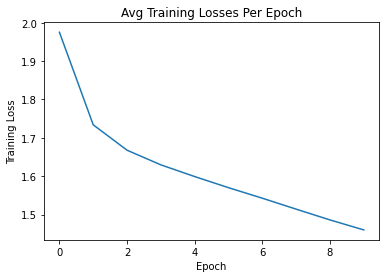

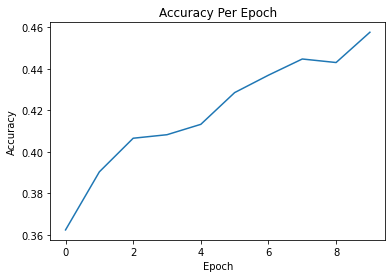

In [9]:
# plot results #################################################################
plt.plot(range(10), loss)
plt.title("Avg Training Losses Per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.show()
plt.plot(range(10), acc)
plt.title("Accuracy Per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

# Problem 4

Write a function that loops through the test data, modifying the images as described.

Run your function for each epsilon in $[0,.05,.1,.15,.2,.25,.3]$, and plot epsilon v. accuracy.

Display the perturbed version of the first image in the test data for each epsilon.

In [11]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Return the perturbed image adding clipping to maintain [-1,1] range
    return torch.clamp(perturbed_image, -1, 1)

0it [00:00, ?it/s]

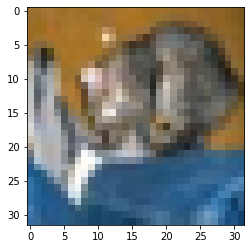

10000it [00:25, 397.78it/s]
0it [00:00, ?it/s]

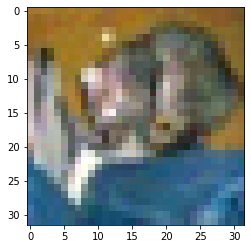

10000it [00:26, 374.55it/s]
0it [00:00, ?it/s]

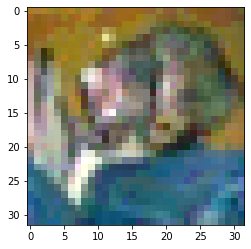

10000it [00:25, 390.34it/s]
0it [00:00, ?it/s]

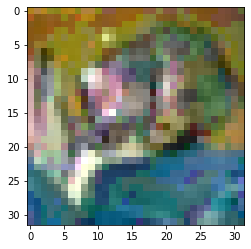

10000it [00:27, 365.59it/s]
0it [00:00, ?it/s]

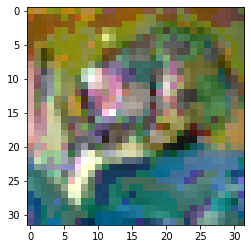

10000it [00:26, 372.22it/s]
0it [00:00, ?it/s]

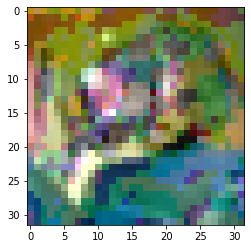

10000it [00:25, 391.69it/s]


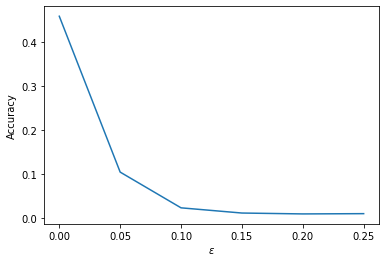

In [12]:
test_load = DataLoader(test_data, batch_size=1, shuffle=False)

def attack(model, data_load, eps):
    acc = []
    model.eval()
    first_iter = True

    for i, (image, label) in tqdm(enumerate(data_load)):
        image, label = image.to(device), label.to(device)
        image.requires_grad = True
        outs = model(image)

        if torch.argmax(outs) == label:
            loss = obj(outs, label)
            opt.zero_grad()
            loss.backward()
            data_grad = image.grad.data
            noisy = fgsm_attack(image, eps, data_grad)
            outs = model(noisy)

            if first_iter:
                ps = noisy.squeeze().detach().cpu().numpy()
                img = (ps/2) + 0.5
                plt.imshow(np.transpose(img, (1, 2, 0)))
                plt.show()
                first_iter = False
    
        acc.append(bool(torch.argmax(outs).cpu() == label.cpu()))

    return np.mean(acc)

# get and plot results #########################################################
acc = []
for eps in [i for i in range(0, 6)]:
    acc.append(attack(model, test_load, eps/20))

plt.plot([i/20 for i in range(0, 6)], acc)
plt.xlabel("$\epsilon$")
plt.ylabel("Accuracy")
plt.show()